Oskari Läntinen <br>
student number 508244 <br>
osanlan@utu.fi  <br>
12, 04, 2020  <br>

# Data Analysis and Knowledge Discovery: Exercise 3, Supervised learning

This is the template for the third exercise. The idea of this exercise is to apply supervised learning to predict the ship type using certain attributes (speed, destination harbour...) and K nearest neighbors (kNN) classifier. The data is available in Moodle course page: shipdata_2020.xlsx. <br> 

General guidance for exercises is given in Moodle course page. <br>

 - answer all the questions below
 - write easily readable code, include explanations what your code does
 - make informative illustrations: include labels for x- and y-axes, legends and captions for your plots
 - do not change anything manually or outside the script in the data file
 - before saving the ipynb file (and possible printing) run: "Restart & Run all", to make sure you return a file that works as expected
 - name your file as DAKD2020_ex3_firstname_lastname.ipynb
 - +1 bonus point requires a correct solution and also thorough analysis. Discuss also how the results could be improved
 - if you encounter problems, Google first. If you can't find an answer to the problem, don't hesitate to ask in the Moodle discussion or directly: pekavir@utu.fi
 - Note! Don't leave it to the last moment! No feedback service during the weekend
 - The deadline is **Friday 4th of December 23:59**

## Data import

Gather *all* packages needed for this notebook here:

In [579]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from math import floor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import LeaveOneOut

import random as rnd

In [580]:
# Reading shipdata_2020 and print first 5 rows
url = "C:\\Users\\Oskari\\Google Drive (osanlan@utu.fi)\\School\\DAaKD\\shipdata_2020.xlsx"
shipdata_orig = pd.read_excel(url)
print(shipdata_orig[:5])

        MMSI    Speed      COG Destination Ship_type  Gross_tonnage  Length  \
0  212209000  10.1377  64.3074      Hamina     Cargo           3416   94.91   
1  212436000  13.5256  77.0755      Hamina    Tanker           6280  116.90   
2  219082000   9.9416  74.6762      Hamina    Tanker           9980  141.20   
3  219083000  11.6038  74.7529      Hamina    Tanker           9980  141.20   
4  219426000  11.9203  56.3253      Hamina    Tanker           3219   99.90   

   Breadth  
0    15.34  
1    18.00  
2    21.90  
3    21.60  
4    15.00  


## Data preprocessing

 - First, find out how many different destinations there are in the data. Do you need to make any preprocessing? **1p**
 - Destination harbor is a categorical variable. It needs to be converted into numerical. Explain, why do you need to make this step? You can use get_dummies from pandas to implement onehot coding for categorical features **1p**
 - Plot Gross tonnage versus the ship Length. Use different colors for different ship types. According to the plot, there is one clear outlier. Find the correct value from marinetraffic.com, and make the correction **1p**
 - It is good to exploit domain knowledge and make some reasonable transformation to the feature values to improve the expected results and/or to avoid redundancy. Find out what gross tonnage means. Make some transformation to Length values to acquire a linear relationship between the transformed length and Gross tonnage values **1p**
 - The numerical variables have quite different ranges. To ensure that all variables can have the same importance on the model, perform Z-score standardization. Perform it for speed, transformed length, and breadth **1p**

Sillamäe is counted twice in "Destination" as "Sillamäe" and "Sillamae". So change "Sillamäe" to "Sillamae".

In [581]:
shipdata = shipdata_orig.replace({"Destination":"Sillamäe"}, "Sillamae")

Converting Destination to numerical variable:
- Many machine learning algorithms require numerical data
- Categorical (string) data doesn't mean anything to the algorithm 
- One hot so that category 4 isn't more/better that category 2

In [582]:
shipdata = pd.get_dummies(shipdata, columns=["Destination"], prefix=["Dest"])

Text(0.5, 1.0, 'Gross tonnage vs Length')

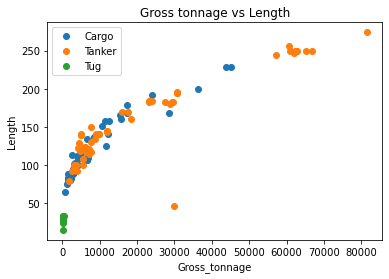

In [583]:
fig, ax  = plt.subplots()

ax.plot(shipdata[shipdata["Ship_type"]=="Cargo"]["Gross_tonnage"], shipdata[shipdata["Ship_type"]=="Cargo"]["Length"],marker="o", linestyle="")
ax.plot(shipdata[shipdata["Ship_type"]=="Tanker"]["Gross_tonnage"], shipdata[shipdata["Ship_type"]=="Tanker"]["Length"], marker="o", linestyle="")
ax.plot(shipdata[shipdata["Ship_type"]=="Tug"]["Gross_tonnage"], shipdata[shipdata["Ship_type"]=="Tug"]["Length"], marker="o", linestyle="")
ax.set_xlabel("Gross_tonnage")
ax.set_ylabel("Length")
ax.legend(shipdata["Ship_type"].unique())
ax.set_title("Gross tonnage vs Length")

In [584]:
# Finding the outlier
# Tanker and length below 75m 
temp = shipdata.loc[shipdata["Ship_type"]=="Tanker"].loc[shipdata["Length"] < 75]
print("MMSI is", temp.iloc[0]["MMSI"])
print("Length is", temp.iloc[0]["Length"])
print("Gross tonnage is", temp.iloc[0]["Gross_tonnage"])
print("Gross tonnage should be 326")
ind = shipdata[shipdata["MMSI"] == 230212000].index[0]
shipdata.at[ind, "Gross_tonnage"] = 326 


MMSI is 230212000
Length is 46.92
Gross tonnage is 30026
Gross tonnage should be 326


Text(0.5, 1.0, 'Gross tonnage vs Length')

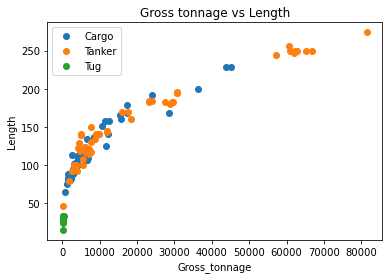

In [585]:
fig, ax  = plt.subplots()

ax.plot(shipdata[shipdata["Ship_type"]=="Cargo"]["Gross_tonnage"], shipdata[shipdata["Ship_type"]=="Cargo"]["Length"],marker="o", linestyle="")
ax.plot(shipdata[shipdata["Ship_type"]=="Tanker"]["Gross_tonnage"], shipdata[shipdata["Ship_type"]=="Tanker"]["Length"], marker="o", linestyle="")
ax.plot(shipdata[shipdata["Ship_type"]=="Tug"]["Gross_tonnage"], shipdata[shipdata["Ship_type"]=="Tug"]["Length"], marker="o", linestyle="")
ax.set_xlabel("Gross_tonnage")
ax.set_ylabel("Length")
ax.legend(shipdata["Ship_type"].unique())
ax.set_title("Gross tonnage vs Length")

 - It is good to exploit domain knowledge and make some reasonable transformation to the feature values to improve the expected results and/or to avoid redundancy. Find out what gross tonnage means. Make some transformation to Length values to acquire a linear relationship between the transformed length and Gross tonnage values **1p**

Gross tonnage (GT, G.T. or gt) is a nonlinear measure of a ship's overall internal volume. 
GT = V * K (V = volume, K = multiplier based on the ship volume)
Length cubed gives us volume which seems to have a linear relationship with gross tonnage

In [586]:
corr, _ = pearsonr(shipdata["Gross_tonnage"], shipdata["Length"])
print('Pearsons correlation: %.3f' % corr)
corr, _ = pearsonr(shipdata["Gross_tonnage"], shipdata["Length"]**3)
print('Pearsons correlation: %.3f' % corr)


Pearsons correlation: 0.909
Pearsons correlation: 0.993


In [587]:
shipdata["Length"] = shipdata["Length"]**3


Text(0.5, 1.0, 'Gross tonnage vs Length^3')

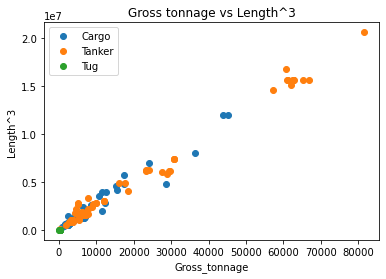

In [588]:
fig, ax  = plt.subplots()

ax.plot(shipdata[shipdata["Ship_type"]=="Cargo"]["Gross_tonnage"], shipdata[shipdata["Ship_type"]=="Cargo"]["Length"],marker="o", linestyle="")
ax.plot(shipdata[shipdata["Ship_type"]=="Tanker"]["Gross_tonnage"], shipdata[shipdata["Ship_type"]=="Tanker"]["Length"], marker="o", linestyle="")
ax.plot(shipdata[shipdata["Ship_type"]=="Tug"]["Gross_tonnage"], shipdata[shipdata["Ship_type"]=="Tug"]["Length"], marker="o", linestyle="")
ax.set_xlabel("Gross_tonnage")
ax.set_ylabel("Length^3")
ax.legend(shipdata["Ship_type"].unique())
ax.set_title("Gross tonnage vs Length^3")

 - The numerical variables have quite different ranges. To ensure that all variables can have the same importance on the model, perform Z-score standardization. Perform it for speed, transformed length, and breadth **1p**

In [589]:
std_scaler = StandardScaler() # Initialise scaler
to_scale = shipdata[["Speed","Length","Breadth"]] # Select columns to standardize
df_std = pd.DataFrame(std_scaler.fit_transform(to_scale)) # Standardization
shipdata["Speed"] = df_std[0] # Set standardized columns back to original data set
shipdata["Length"] = df_std[1]
shipdata["Breadth"] = df_std[2]
shipdata


,MMSI,Speed,COG,Ship_type,Gross_tonnage,Length,Breadth,Dest_Hamina,Dest_Helsinki,Dest_Kotka,...,Dest_Paldiski,Dest_Porvoo,Dest_Primorsk,Dest_Sillamae,Dest_Tallinn,Dest_Ust-Luga,Dest_Valko-Loviisa,Dest_Viipuri,Dest_Vuosaari,Dest_Vysotsk
0,212209000,-0.161299,64.3074,Cargo,3416,-0.569303,-0.489104,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,212436000,1.580209,77.0755,Tanker,6280,-0.405892,-0.220696,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,219082000,-0.262102,74.6762,Tanker,9980,-0.137933,0.172834,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,219083000,0.592331,74.7529,Tanker,9980,-0.137933,0.142563,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,219426000,0.755024,56.3253,Tanker,3219,-0.538041,-0.523412,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,273374820,-0.211726,74.6253,Tanker,4979,-0.154887,-0.351873,0,0,0,...,0,0,0,0,0,0,0,0,0,1
130,273385070,-0.565847,74.5454,Tanker,4979,-0.154887,-0.327656,0,0,0,...,0,0,0,0,0,0,0,0,0,1
131,273388150,-0.351956,68.7159,Tanker,5075,-0.142528,-0.335728,0,0,0,...,0,0,0,0,0,0,0,0,0,1
132,636092755,0.361837,73.7013,Tanker,23240,0.591202,0.724786,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Classification accuracy with random training and test sets

Predict the **ship type** using **speed, destination, transformed length, and breadth** as features. Find an estimation for the classification accuracy (number of correctly classified ships to the total number of ships) using *random training and test sets*. <br>
 - Produce training and test data **1p**
     - Gather the normalized features and one-hot-coded destination columns as array __X__ (input variables), and the ship type as array **y** (output variable)     
     - Divide the data randomly into training (20%) and test (80%) sets
     - Do you need to use stratification? Explain your decision
 - Train the model and test its performance **1p**
     - Use kNN classifier with k=3
     - Print out the confusion matrix. How does the model perform with different ship types?
     - What is the (total) classification accuracy?
 - Repeat the calculation 1000 times with different split of training/test data, and make a histogram of the results for classification accuracy **1p**
 - Discuss your results **1p**

Stratification should be used since the smallest category is smaller than the 20% training group

In [590]:
X = shipdata.drop(columns=["MMSI", "COG", "Gross_tonnage", "Ship_type"])
y = shipdata["Ship_type"]

# Stratify and split into test and train groups
X_train, X_test, y_train, y_test = model_s.train_test_split(X, y, random_state=1, test_size=0.8, stratify=shipdata["Ship_type"])


Text(0.5, 1.0, 'Confusion matrix')

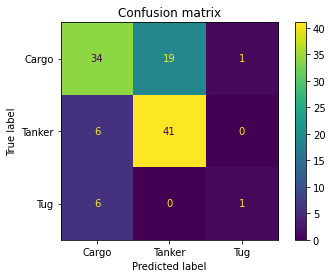

In [591]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train,y_train)

a = plot_confusion_matrix(neigh, X_test, y_test)
a.ax_.set_title("Confusion matrix")

How does the model fare with different ship types?

Cargos and tankers get mixed up but tugs can be identified

In [592]:
print( "Classification accuracy is", neigh.score(X_test, y_test))

Classification accuracy is 0.7037037037037037


In [593]:
rnd.seed()
scores = []
for i in range(1000):
    a = rnd.randrange(5,130,5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=a, stratify=shipdata["Ship_type"])
    
    score = neigh.score(X_test, y_test)
    scores.append(score)

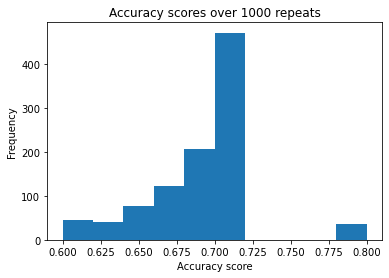

In [594]:
plt.hist(scores)
plt.title("Accuracy scores over 1000 repeats")
plt.xlabel("Accuracy score")
plt.ylabel("Frequency")
plt.show()

Most scores in the 0.7-0.8 range as expected by the confusion matrix. Couple in the high 0.95+, completely correct predictions maybe? Or favourable splits?



## Classification accuracy using leave-one-out cross validation

Again, predict the **ship type** using **speed, destination, transformed length, and breadth** of the ship as features. Find an estimation for the classification accuracy using *leave-one-out cross validation (LOO CV)*. <br>

 - Use leave-one-out cross validation to estimate the model performance **1p**
     - Use kNN classifier with k=3
     - What is the classification accuracy? Compare the result with the one you got in the previous task
 - Which method gives better evaluation of the performance of the classifier with this data set? Explain your choice **1p**

In [595]:
X = shipdata.drop(columns=["MMSI", "COG", "Gross_tonnage", "Ship_type"])
y = shipdata["Ship_type"]

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train,y_train)

loo = model_s.LeaveOneOut()
loo.get_n_splits(X)

scores = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scores.append(neigh.score(X_test, y_test))
print( "Classification accuracy is", np.mean(scores))

Classification accuracy is 0.8283582089552238


LeaveOneOut seems to be a little bit better than random splits. Performance is slower though.

## Model selection with leave-one-out cross validation

- Select the best model (kNN with selection of k) using leave-one-out cross validation **2p**
    - Repeat the model performance estimation with values k=1...30
    - Which value of k produces the best classification accuracy?
    - If the number of k is still increased, what is the limit that the classification accuracy approaches? Why?
- Can you say something about the performance of this *selected* model with new, unseen data? Explain, how you could you estimate the performance of this selected model. **1p**

In [596]:
X = shipdata.drop(columns=["MMSI", "COG", "Gross_tonnage", "Ship_type"])
y = shipdata["Ship_type"]

loo = model_s.LeaveOneOut()
loo.get_n_splits(X)
scores = []
score_avg = []
for k in range(1,31):
    neigh = KNeighborsClassifier(n_neighbors=k)
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        neigh.fit(X_train,y_train)
        scores.append(neigh.score(X_test, y_test))    
    score_avg.append(np.mean(scores))

In [597]:
print("Best score is", max(score_avg), "at k =", score_avg.index(max(score_avg)))

Best score is 0.744136460554371 at k = 6


In [598]:
for k in range(30,130,10):   
    neigh = KNeighborsClassifier(n_neighbors=k)
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        neigh.fit(X_train,y_train)
        scores.append(neigh.score(X_test, y_test))
    print(np.mean(scores))

0.7279730380356283
0.7273787313432836
0.7261420171867933
0.7243195785776997
0.7226012793176972
0.7205638474295191
0.7172246873739411
0.7140612725844462
0.7097206276310754
0.7044776119402985


Increasing k further makes accuracy drop further. Increasing k increases split size all the way up to whole data set

## Testing with training data (this should not be used!)

- Repeat the previous task but use the whole data for training **2p**
    - Plot the resulting classification accuracy versus k=1...30. Include the values from the previous task in the same figure
    - Comment your result. Why shouldn't you test with training data?

In [599]:
X = shipdata.drop(columns=["MMSI", "COG", "Gross_tonnage", "Ship_type"])
y = shipdata["Ship_type"]

loo = model_s.LeaveOneOut()
loo.get_n_splits(X)
score2 = []
score_avg2 = []
for k in range(1,31):
    neigh = KNeighborsClassifier(n_neighbors=k)
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X, X.iloc[test_index]
        y_train, y_test = y, y[test_index]
        
        neigh.fit(X_train,y_train)
        score2.append(neigh.score(X_test, y_test))    
    score_avg2.append(np.mean(score2))
print(score_avg2)

[1.0, 0.9291044776119403, 0.9104477611940298, 0.8955223880597015, 0.8776119402985074, 0.8694029850746269, 0.8560767590618337, 0.8498134328358209, 0.8432835820895522, 0.8365671641791045, 0.830393487109905, 0.8252487562189055, 0.8203214695752009, 0.8160980810234542, 0.8114427860696517, 0.8083022388059702, 0.8046532045654082, 0.8018242122719734, 0.7985074626865671, 0.7955223880597015, 0.7924662402274343, 0.7893487109905021, 0.7868267358857884, 0.7845149253731343, 0.7823880597014925, 0.7807118254879449, 0.7794361525704809, 0.7779850746268657, 0.7766340710241894, 0.7751243781094528]


Text(0.5, 1.0, 'Effect of testing with training data')

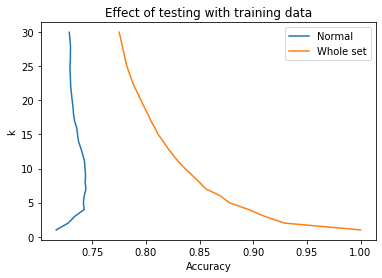

In [600]:
fig, ax  = plt.subplots()
ax.plot(score_avg,range(1,31))
ax.plot(score_avg2,range(1,31))

ax.set_xlabel("Accuracy")
ax.set_ylabel("k")
ax.legend(["Normal", "Whole set"])
ax.set_title("Effect of testing with training data")

Testing with training data leads to pretty high accuracies on lower k values 